# MLOPS project - Model design using MLFlow

Author : **Nicolas Deronsart**

In [1]:
import mlflow
import subprocess

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline

from spacy.lang.fr.stop_words import STOP_WORDS as french_stopwords

import matplotlib.pyplot as plt
import seaborn as sns

## MLFlow tracking

We set up MLFlow tracking to monitor the model training and evaluation.

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.sklearn.autolog(log_datasets=False)
mlflow.set_experiment("model_design")

<Experiment: artifact_location='mlflow-artifacts:/638688685417919419', creation_time=1699969570525, experiment_id='638688685417919419', last_update_time=1699969570525, lifecycle_stage='active', name='model_design', tags={}>

## Import the data

Before training a first model, we need to get the training and validation dataset.

In [3]:
df = pd.read_csv('../data/train.csv')
df = df.drop('Unnamed: 0', axis=1)
df

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/c...,Si vous cherchez du cinéma abrutissant à tous ...,0
1,http://www.allocine.fr/film/fichefilm-172430/c...,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,http://www.allocine.fr/film/fichefilm-15105/cr...,"Et si, dans les 5 premières minutes du film, l...",0
3,http://www.allocine.fr/film/fichefilm-188629/c...,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,http://www.allocine.fr/film/fichefilm-23514/cr...,"Premier film de la saga Kozure Okami, ""Le Sabr...",1
...,...,...,...
159995,http://www.allocine.fr/film/fichefilm-132387/c...,Un rythme bien trop lent et un Ashton Kutcher ...,0
159996,http://www.allocine.fr/film/fichefilm-53313/cr...,Monsieur Duchovny vous êtes aussi piètre acteu...,0
159997,http://www.allocine.fr/film/fichefilm-248258/c...,Complètement différent des films de la série C...,1
159998,http://www.allocine.fr/film/fichefilm-268731/c...,Alors franchement pour le moment c'est le meil...,1


In [4]:
df_valid = pd.read_csv('../data/valid.csv')
df_valid = df_valid.drop('Unnamed: 0', axis=1)
df_valid

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/cr...,Ce film est tout ce qu'il y a de plus sympa. M...,0
1,http://www.allocine.fr/film/fichefilm-272/crit...,"The Wall a été réalisé par Alan Parker (Fame, ...",1
2,http://www.allocine.fr/film/fichefilm-60134/cr...,"Encore un film majeur tres mal distribué, comm...",1
3,http://www.allocine.fr/film/fichefilm-31396/cr...,L'idée est très bonne mais le film manque de r...,0
4,http://www.allocine.fr/film/fichefilm-135195/c...,Un petit nanar rigolo a regarder. A voir une f...,0
...,...,...,...
19995,http://www.allocine.fr/film/fichefilm-39142/cr...,Ce petit film tourné en 18 jours pour la somme...,1
19996,http://www.allocine.fr/film/fichefilm-8171/cri...,"Le roman de Forsyth, d'où est tiré le scénario...",0
19997,http://www.allocine.fr/film/fichefilm-228026/c...,"Qu'on aime ou pas ""Toni Erdmann"" - et au sorti...",1
19998,http://www.allocine.fr/film/fichefilm-219994/c...,"Un film qui a fait un certain buzz médiatique,...",1


Now, we can create a pipeline to train and predict the polaririty prediction model.

## Pipeline creation

We can create a pipeline that first vectorize the text with a TF-IDF and then use the model.

Our pipeline can be used to train the model on the whole training set, and then use it to predict the polarity of the test set.

In [5]:
def evaluate(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'ROC AUC: {roc_auc}')
    
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    return accuracy, f1, precision, recall, roc_auc

2023/11/14 16:52:58 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('tfidf', TfidfVectorizer(stop_words=['derriere', 'eh', 'celui', 'en', 'stop', 'avant',
                            'son', 'pourrais', 'toi-même', 'auront', 'être',
                            'celle-ci', 'miens', 'feront', 'antérieur',
                            'seulement', 'plutot', 'compris', 'divers', 'hue',
                            'ouste', 'parfois', 'via', 'cinquième', 'parlent',
                            'dessous', 'quant-à-soi', 'avec', 'dite', 'tenir', ...])), ('model', Logi...`
2023/11/14 16:52:58 WARNING mlflow.utils: Truncated the value of the key `tfidf__stop_words`. Truncated value: `['derriere', 'eh', 'celui', 'en', 'stop', 'avant', 'son', 'pourrais', 'toi-même', 'auront', 'être', 'celle-ci', 'miens', 'feront', 'antérieur', 'seulement', 'plutot', 'compris', 'divers', 'hue', 'ouste', 'parfois', 'via', 'cinquième', 'parlent', 'dessous', 'quant-à-soi', 'avec', 'dite'

Accuracy: 0.9185
F1: 0.9178344591188627
Precision: 0.9065923122883888
Recall: 0.9293589220089833
ROC AUC: 0.9187170933055501


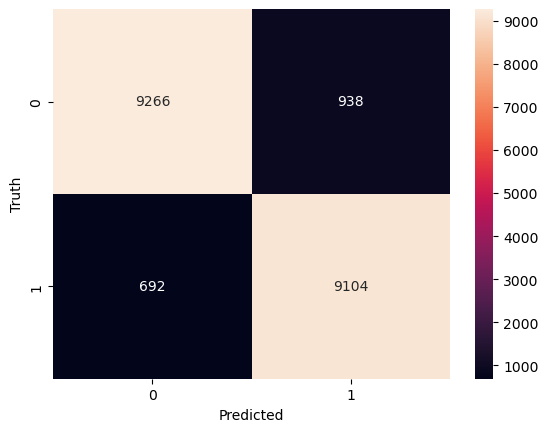

Successfully registered model 'Sentiment analysis pipeline with tfidf and logistic regression'.
2023/11/14 16:53:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sentiment analysis pipeline with tfidf and logistic regression, version 1
Created version '1' of model 'Sentiment analysis pipeline with tfidf and logistic regression'.


In [6]:
with mlflow.start_run(description='Sentiment analysis pipeline with tfidf and logistic regression'):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=list(french_stopwords))),
        ('model', LogisticRegression(max_iter=500, random_state=42))
    ])
    pipe.fit(df['review'], df['polarity'])

    y_pred = pipe.predict(df_valid['review'])

    accuracy, f1, precision, recall, roc_auc = evaluate(pipe, df_valid['review'], df_valid['polarity'])
    
    experiment_tags = {
        "vectorizer": "TfidfVectorizer",
        "classifier": "LogisticRegression",
        "mlflow.source.name": "model_design_2.ipynb",
        "mlflow.note.content": "Sentiment analysis on movies reviews",
        "mlflow.source.git.commit": subprocess.check_output(["git", "rev-parse", "HEAD"]),
        "dataset": "train.csv",
    }
    mlflow.set_tags(experiment_tags)

    experiment_metrics = {
        'validation_accuracy': accuracy,
        'validation_f1': f1,
        'validation_precision': precision,
        'validation_recall': recall,
        'validation_roc_auc': roc_auc
    }
    mlflow.log_metrics(experiment_metrics)
    
    mlflow.sklearn.log_model(pipe, 
                             registered_model_name="Sentiment analysis pipeline with tfidf and logistic regression",
                             artifact_path="sklearn_model")

We have good results with our pipeline. We can now track our model with MLFlow.